<a href="https://colab.research.google.com/github/Delsa2001/DSGP/blob/Inuka/final3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary components from Keras for building and training the CNN model
from keras.models import Sequential                          # To define a sequential stack of layers for the model
from keras.layers import Conv2D                              # Convolutional layer for feature extraction
from keras.layers import MaxPooling2D                        # Max pooling to down-sample feature maps
from keras.layers import Flatten                             # Flattens 2D data to 1D for dense layers
from keras.layers import Dense                               # Fully connected (dense) layer for classification
from keras.layers import Dropout                             # Dropout layer to prevent overfitting
from keras.layers import BatchNormalization                  # Normalizes activations for faster training and stability
from keras.layers import Activation                          # Adds activation functions (e.g., ReLU)
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Callbacks for early stopping and saving model checkpoints
from keras.models import load_model                          # Utility to load pre-trained models

# Preprocessing layers
from keras.layers import Rescaling                           # Normalizes pixel values (e.g., scaling to range 0–1)

# Importing TensorFlow as the core library for machine learning and deep learning
import tensorflow as tf
import os                                                    # Provides functionalities to interact with the operating system


In [ ]:
# Configuring notebook

                                                             # Setting a fixed seed value for random operations to ensure reproducibility in experiments
seed = 123

# Defining colors for the notebook's visualization or plots (used for aesthetic purposes)
paper_color = '#EEF6FF'  # Background color for paper (e.g., charts, figures)
bg_color = '#EEF6FF'     # Background color for the overall layout


In [ ]:
# Function to resize images
def image_resizer(paths):
    """
    This function resizes the input images to a fixed size of 350x250 pixels.
    Arguments:
        paths (list): A list of file paths to the images.
    Returns:
        resized_images (list): A list of resized image objects.
    """
    from concurrent.futures import ThreadPoolExecutor          # For parallel execution
    from PIL import Image                                      # Image processing library

                                                               # Using a thread pool to process images in parallel for faster execution
    with ThreadPoolExecutor() as executor:
        resized_images = list(executor.map(lambda x: Image.open(x).resize((350, 250)), paths))
    return resized_images



def plot_images_list(images, title, subtitle):                  # Function to plot a grid of images
    '''
    This function helps to plot a matrix of images from a list.
    Arguments:
        images (list): A list of image paths to display.
        title (str): The title of the plot.
        subtitle (str): A subtitle for the plot.
    '''
    import plotly.subplots as sp                                # For creating subplots
    import plotly.graph_objs as go                              # For creating plotly images


    fig = sp.make_subplots(rows=3, cols=3)                      # Create a 3x3 grid for plotting the images


    images = image_resizer(images)                              # Resize the images using the previously defined function

    traces = []
    for i in range(min(9, len(images))):                        # Plot up to 9 images
        img = go.Image(z=images[i])                             # Create a plotly image object
        traces.append((img, i // 3 + 1, i % 3 + 1))             # Assign image to a grid position


    fig.add_traces([trace[0] for trace in traces],              # Add the image traces to the figure
                  rows=[trace[1] for trace in traces],
                  cols=[trace[2] for trace in traces])


    fig.update_layout(                                          # Customize the layout of the plot
        title={'text': f'<b>{title}<br>  <i><sub>{subtitle}</sub></i></b>',
               'font': dict(size=22)},                          # Styling the title and subtitle
        height=800,                                             # Plot height
        width=800,                                              # Plot width
        margin=dict(t=110, l=80),                               # Adjust margins
        plot_bgcolor=bg_color,                                  # Background color
        paper_bgcolor=paper_color                               # Paper background color
    )


    fig.show()                                                # Display the plot


In [ ]:
                                                                   # Configuring GPU for TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')         # Lists all available GPUs on the system.


if gpus:                                                           # Check if any GPUs are available
    try:

        for gpu in gpus:

            tf.config.experimental.set_memory_growth(gpu, True)     # Enable dynamic memory allocation for each GPU


        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')  # Set the first GPU as the visible device (if multiple GPUs exist)


        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0") # Define a distribution strategy to use the selected GPU

        print('\nGPU Found! Using GPU...')                          # Notify the user that a GPU is available and being used.
    except RuntimeError as e:

        print(e)
else:

    strategy = tf.distribute.get_strategy()                          #use the default CPU strategy
    print('Number of replicas:', strategy.num_replicas_in_sync)      # Display the number of replicas for the strategy


Number of replicas: 1


In [ ]:
from google.colab import drive
import os


drive.mount('/content/drive')            # Mount Google Drive


train_dir = '/content/drive/My Drive/archive/Train/Train'
test_dir = '/content/drive/My Drive/archive/Test/Test'
val_dir = '/content/drive/My Drive/archive/Validation/Validation'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

directories = {                                # Assign names to each directory
    train_dir: 'Train',
    test_dir: 'Test',
    val_dir: 'Validation'
}


subfolders = ['Healthy', 'Powdery', 'Rust']   # Define subfolders

print('\n* * * * * Number of files in each folder * * * * *\n')

                                                                # Counting the total number of images in each subfolder for every directory
for dir, name in directories.items():                           # Iterate over each directory and its label
    total = 0                                                   # Initialize total count for each directory
    for sub in subfolders:                                      # Iterate over the subfolders (classes)
        path = os.path.join(dir, sub)                           # Construct the full path to the subfolder
        if os.path.exists(path):                                # Check if the path exists
                                                                # Count the number of files in the subfolder
            num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
            total += num_files                                  # Add the count to the directory total
            print(f'{name}/{sub}: {num_files}')                 # Print the count for the current subfolder
        else:
                                                                # If the subfolder doesn't exist, print an error
            print(f'{name}/{sub}: Directory not found')
    print(f'\n  Total in {name}: {total}')                      # Print the total number of images in the directory
    print("-" * 80)                                             # Separator for readability



* * * * * Number of files in each folder * * * * *

Train/Healthy: 469
Train/Powdery: 456
Train/Rust: 444

  Total in Train: 1369
--------------------------------------------------------------------------------
Test/Healthy: 50
Test/Powdery: 50
Test/Rust: 50

  Total in Test: 150
--------------------------------------------------------------------------------
Validation/Healthy: 20
Validation/Powdery: 20
Validation/Rust: 20

  Total in Validation: 60
--------------------------------------------------------------------------------


In [ ]:
import os
from PIL import Image

                                                                               # Initialize an empty set to store unique dimensions
unique_dimensions = set()                                                      # A set is used to automatically handle duplicates

                                                                               # Iterate over each directory and subfolder
for dir, name in directories.items():                                          # Loop through the dataset directories (Train, Test, Validation)
    for sub in subfolders:                                                     # Loop through each subfolder (Healthy, Powdery, Rust)
        folder_path = os.path.join(dir, sub)                                   # Construct the path to the subfolder

                                                                               # Check if the folder path exists (to avoid errors)
        if os.path.exists(folder_path):
            for file in os.listdir(folder_path):                               # Loop through all files in the subfolder
                image_path = os.path.join(folder_path, file)                   # Construct the full path to the image file

                                                                               # Filter only image files (optional, depending on file types present)
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Check for image extensions
                    with Image.open(image_path) as img:                        # Open the image file
                        unique_dimensions.add(img.size)                        # Add the dimensions (width, height) to the set

                                                                               # Output the unique dimensions
if len(unique_dimensions) == 1:                                                # Check if all images have the same dimensions
    print(f"\nAll images have the same dimensions: {unique_dimensions.pop()}") # Print the single dimension
else:
                                                                               # Print the total count of unique dimensions and list them
    print(f"\nFound {len(unique_dimensions)} unique image dimensions: {unique_dimensions}")



Found 8 unique image dimensions: {(4032, 3024), (4000, 2672), (4000, 3000), (5184, 3456), (2592, 1728), (3901, 2607), (4608, 3456), (2421, 2279)}


In [ ]:
import os
from PIL import Image
from collections import defaultdict                                            # Importing defaultdict for easier counting

                                                                               # Dictionary to count occurrences of each dimension
dims_counts = defaultdict(int)                                                 # Initialize a dictionary where missing keys default to 0

                                                                               # Iterate over each directory and subfolder
for dir, name in directories.items():                                          # Loop through dataset directories (Train, Test, Validation)
    for sub in subfolders:                                                     # Loop through each subfolder (Healthy, Powdery, Rust)
        folder_path = os.path.join(dir, sub)                                   # Construct the subfolder path

                                                                               # Check if folder exists to avoid errors
        if os.path.exists(folder_path):                                        # Verify the subfolder exists
            for file in os.listdir(folder_path):                               # Loop through all files in the subfolder
                image_path = os.path.join(folder_path, file)                   # Construct full path to the image file

                                                                               # Filter for common image files
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Process only image files
                    with Image.open(image_path) as img:                        # Open the image file
                        dims_counts[img.size] += 1                             # Increment count for the specific dimension

                                                                               # Print the count of each dimension
for dimension, count in dims_counts.items():                                   # Loop through dimensions and their counts
    print(f"\nDimension {dimension}: {count} images")                          # Print dimension and the count of images with it



Dimension (4000, 2672): 1164 images

Dimension (4000, 3000): 92 images

Dimension (2421, 2279): 1 images

Dimension (5184, 3456): 98 images

Dimension (2592, 1728): 135 images

Dimension (4608, 3456): 72 images

Dimension (4032, 3024): 16 images

Dimension (3901, 2607): 1 images


In [ ]:
import os
from PIL import Image
import numpy as np

                                                                          # Initialize flags for data type and range checks
all_uint8 = True                                                          # Flag to track if all images have uint8 data type
all_in_range = True                                                       # Flag to check if all pixel values are in the range 0-255

                                                                          # Iterate over each directory and subfolder
for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

                                                                         # Check if folder exists to avoid errors
        if os.path.exists(folder_path):
            for file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, file)

                                                                         # Filter for image files only
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Process only valid image files
                    with Image.open(image_path) as img:                  # Open the image file
                        img_array = np.array(img)                        # Convert the image to a NumPy array

                                                                         # Check if data type is not uint8
                    if img_array.dtype != 'uint8':                       # Verify that the array's data type is uint8
                        all_uint8 = False                                # Set flag to False if a non-uint8 image is found

                                                                         # Check if pixel values are out of the 0-255 range
                    if img_array.min() < 0 or img_array.max() > 255:     # Ensure pixel values are within valid range
                        all_in_range = False                             # Set flag to False if out-of-range values are found


if all_uint8:
    print(" - All images are of data type uint8\n")                        # Confirm if all images have uint8 data type
else:
    print(" - Not all images are of data type uint8\n")                    # Indicate some images are of a different data type

if all_in_range:
    print(" - All images have pixel values ranging from 0 to 255")         # Confirm all pixel values are in range
else:
    print(" - Not all images have pixel values ranging from 0 to 255")     # Indicate presence of out-of-range values


 - All images are of data type uint8

 - All images have pixel values ranging from 0 to 255


In [ ]:
import random

                                                          # Loading the directory for each class in the training dataset
train_healthy_dir = train_dir + "/" + 'Healthy'
train_rust_dir = train_dir + "/" + 'Rust'
train_powdery_dir = train_dir + "/" + 'Powdery'

                                                          # Selecting 9 random pictures from each directory
healthy_files = random.sample(os.listdir(train_healthy_dir), 9)
rust_files = random.sample(os.listdir(train_rust_dir), 9)
powdery_files = random.sample(os.listdir(train_powdery_dir), 9)

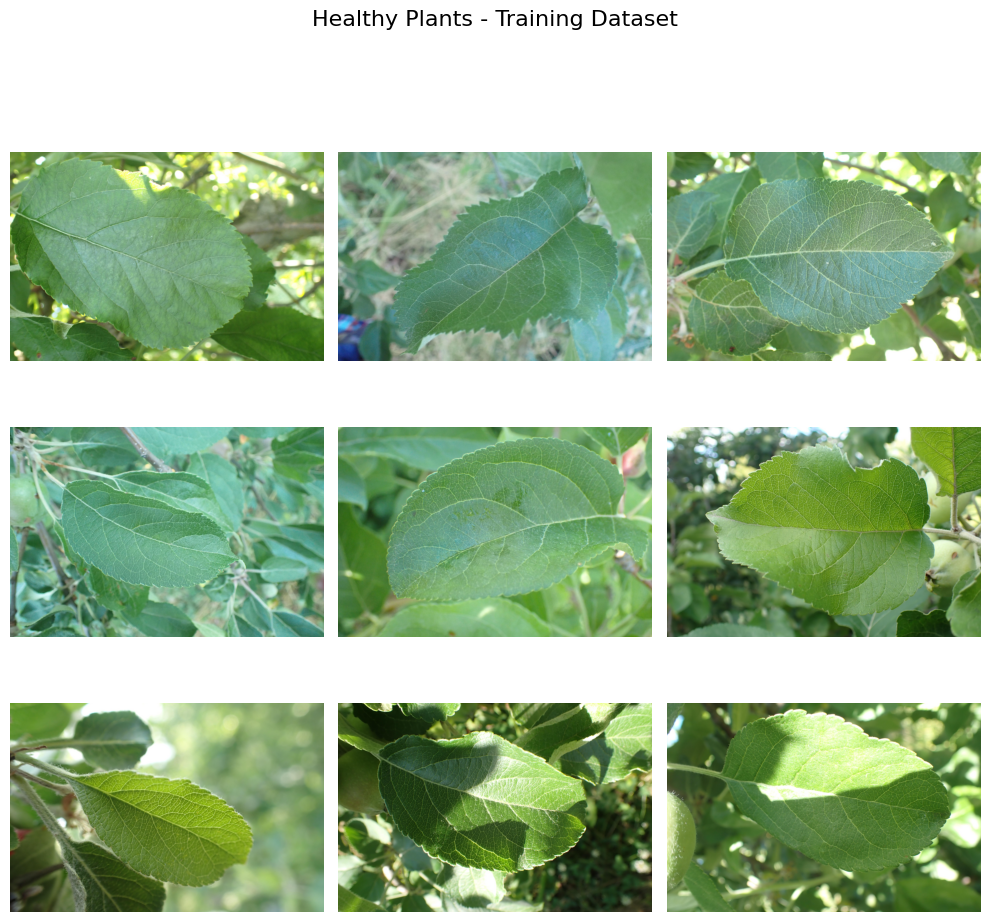

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images_list(image_paths, title, dataset_type):
    plt.figure(figsize=(10, 10))
    plt.suptitle(f"{title} - {dataset_type}", fontsize=16)

    for i, image_path in enumerate(image_paths):
        img = mpimg.imread(image_path)
        plt.subplot(3, 3, i + 1)                    # Create a 3x3 grid for the 9 images
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

                                                   # Plotting healthy plants
healthy_images = [os.path.join(train_healthy_dir, f) for f in healthy_files]
plot_images_list(healthy_images, "Healthy Plants", "Training Dataset")

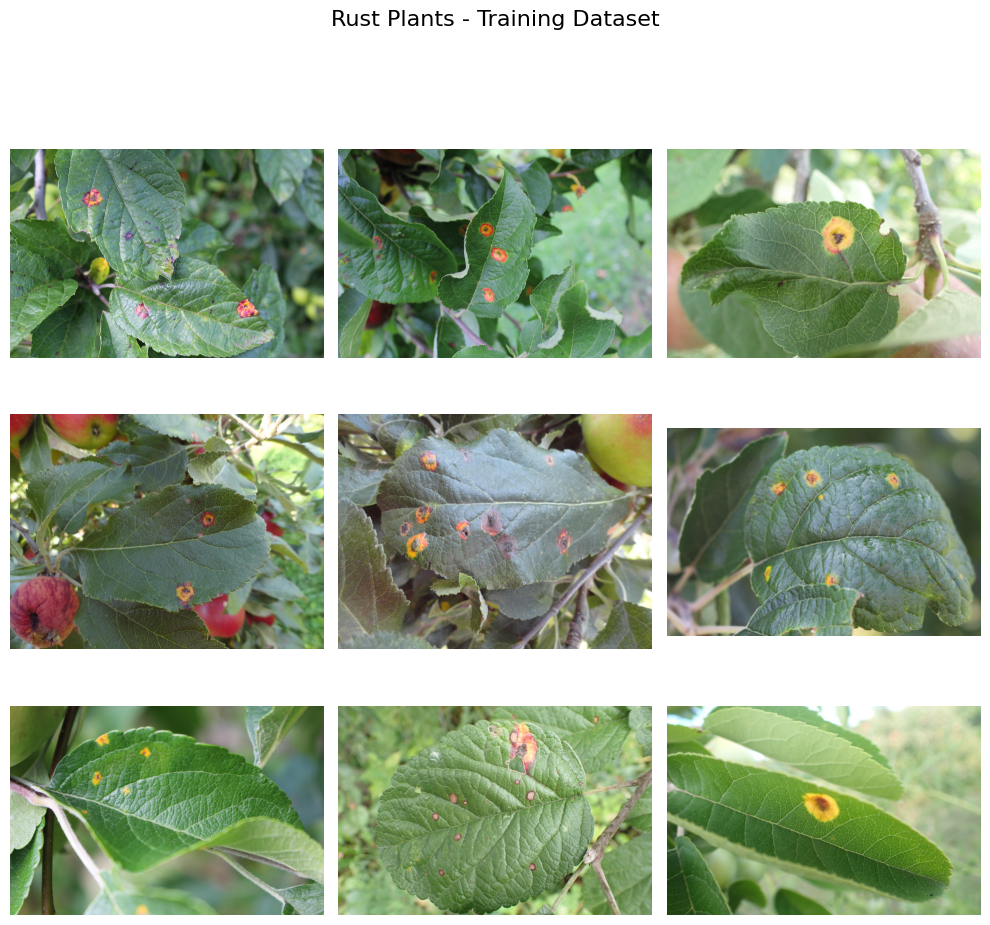

In [ ]:
# Plotting rust plants
rust_images = [os.path.join(train_rust_dir, f) for f in rust_files]
plot_images_list(rust_images, "Rust Plants", "Training Dataset")

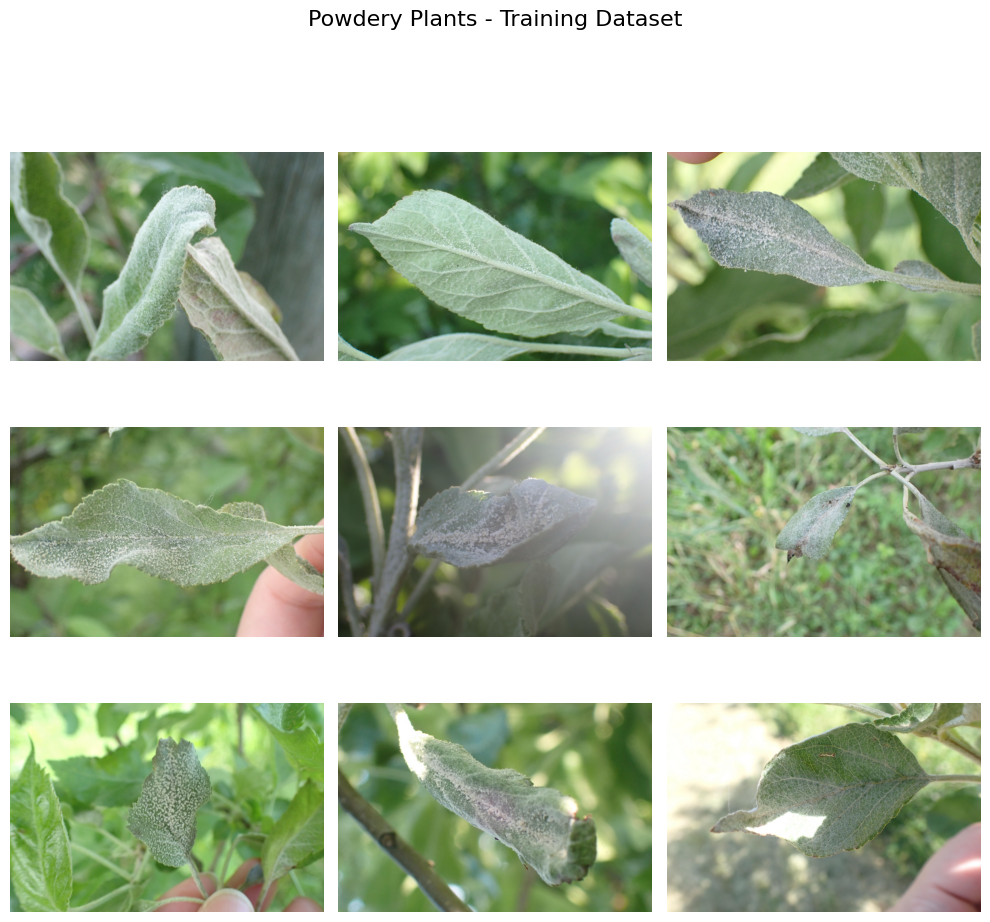

In [ ]:
# Plotting powdery plants
powdery_images = [os.path.join(train_powdery_dir, f) for f in powdery_files]
plot_images_list(powdery_images, "Powdery Plants", "Training Dataset")

Preprossesing

In [ ]:
import tensorflow as tf

                                                       # seed value for reproducibility
seed = 42

                                                       # Creating a Dataset for the Training data
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,                                         # Directory where the Training images are located
    labels='inferred',                                 # Classes will be inferred according to the structure of the directory
    label_mode='categorical',
    class_names=['Healthy', 'Powdery', 'Rust'],
    batch_size=16,                                     # Number of processed samples before updating the model's weights
    image_size=(256, 256),                             # Defining a fixed dimension for all images
    shuffle=True,                                      # Shuffling data
    seed=seed,                                         # Random seed for shuffling and transformations
    validation_split=None,                             # Set to None instead of 0 if no validation split is needed
    crop_to_aspect_ratio=True                          # Resize images without aspect ratio distortion
)

Found 1369 files belonging to 3 classes.


In [ ]:
                                                        # Creating a dataset for the Test data
test = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,
    image_size = (256, 256),
    shuffle = True,
    seed = seed,
    validation_split = 0,
    crop_to_aspect_ratio = True
)

Found 150 files belonging to 3 classes.


In [ ]:
                                                          # Creating a dataset for the validate data
validation = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,
    image_size = (256, 256),
    shuffle = True,
    seed = seed,
    validation_split = 0,
    crop_to_aspect_ratio = True
)

Found 60 files belonging to 3 classes.


In [ ]:
print('\nTraining Dataset:', train)
print('\nTesting Dataset:', test)
print('\nValidation Dataset:', validation)


Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

Testing Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [ ]:
                                                     # Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0

Maximum pixel value in the Validation dataset 255


In [ ]:
from tensorflow.keras.layers import Rescaling

                                                       # Defining scaler to normalize values between 0 and 1
scaler = Rescaling(1.0 / 255)

In [ ]:
                                                       # Rescaling datasets
train = train.map(lambda x, y: (scaler(x), y))
test = test.map(lambda x, y: (scaler(x), y))
validation = validation.map(lambda x, y: (scaler(x), y))

In [ ]:
                                                        # Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 1.0


In [ ]:
import tensorflow as tf

                                           # Define the seed for reproducibility
seed = 42

                                           # Creating data augmentation pipeline
augmentation = tf.keras.Sequential(
    [

        tf.keras.layers.RandomRotation(    # Random rotation layer
            factor=(-0.25, 0.3),
            fill_mode='reflect',
            interpolation='bilinear',
            seed=seed
        ),
        tf.keras.layers.RandomBrightness(  # Random brightness layer
            factor = (-.45, .45),
            value_range = (0.0, 1.0),
            seed = seed)
        ,

        tf.keras.layers.RandomContrast(   # Random contrast layer
           factor = (.5),
           seed = seed)

    ]
)

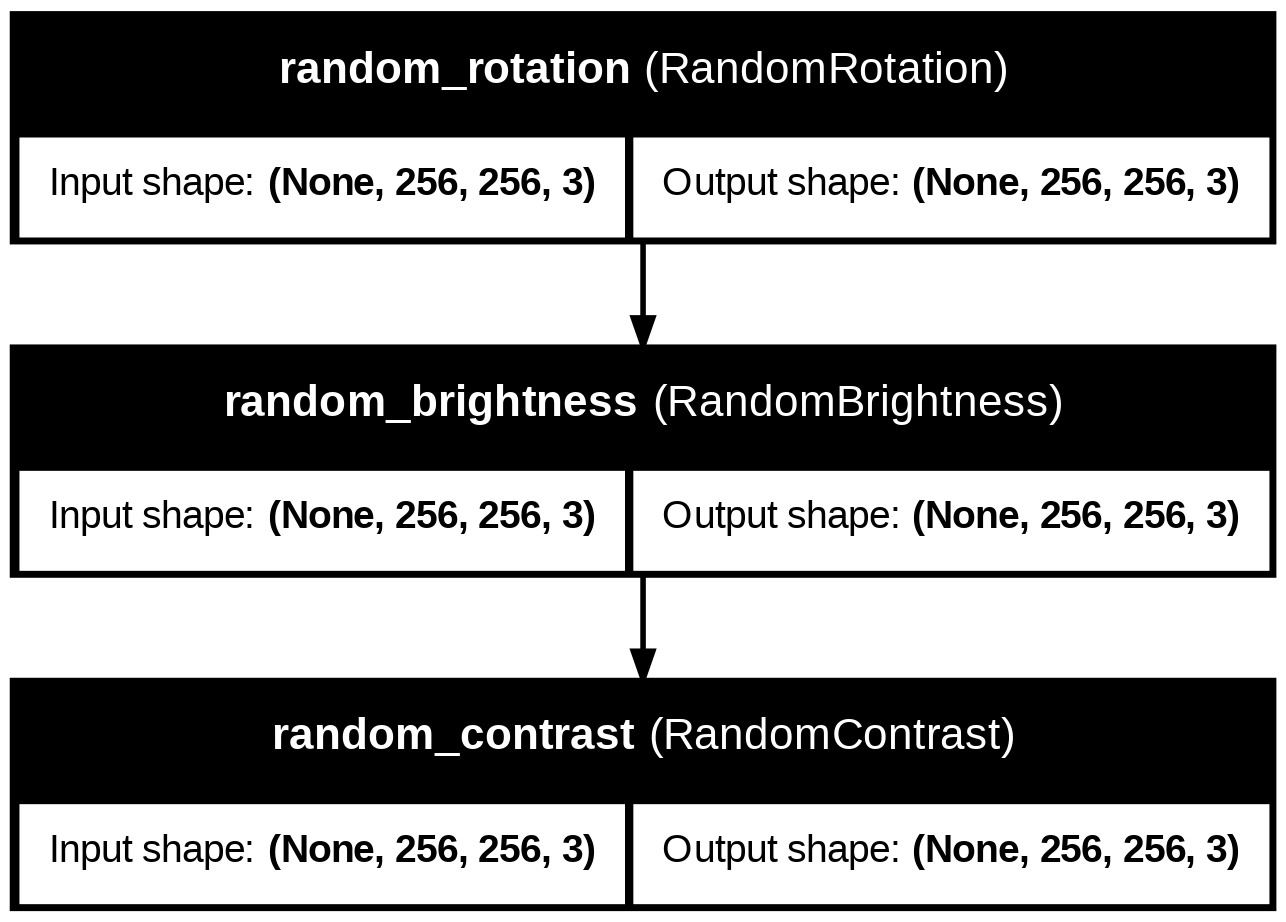

In [ ]:
augmentation.build((None, 256, 256, 3))                 # Building model
                                                        # Plotting model
tf.keras.utils.plot_model(augmentation,
                          show_shapes = True,
                          show_layer_names = True,
                          expand_nested = True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

# Define the strategy for multi-GPU training (if applicable)
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Model architecture (already defined)
    model = Sequential()

    # Add layers to the model
    model.add(augmentation)  # Data augmentation

    # Feature Learning Layers
    model.add(Conv2D(32, (3, 3), strides=1, padding='same', input_shape=(256, 256, 3)))
    model.add(BatchNormalization())  # Adding Batch Normalization before activation
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.3))

    # Flattening tensors
    model.add(Flatten())

    # Fully-Connected Layers
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(3, activation='softmax'))


    # Choose an optimizer (e.g., RMSprop or Adam)
    optimizer = tf.keras.optimizers.Adam()

    # Compile the model with the optimizer, loss function, and metrics
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',  # Since this is a multi-class classification
                  metrics=['accuracy'])

    # Define callbacks (if any)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)

    # Now, fit the model under strategy scope
    try:
        history = model.fit(
            train,
            epochs=50,
            validation_data=test,
            callbacks=[early_stopping, checkpoint]
        )
    except Exception as e:
        print("An error occurred:", e)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 957s 11s/step - accuracy: 0.3640 - loss: 53.1502 - val_accuracy: 0.3867 - val_loss: 1.4917
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 946s 11s/step - accuracy: 0.4428 - loss: 8.0937 - val_accuracy: 0.3333 - val_loss: 1.1099
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 960s 11s/step - accuracy: 0.5494 - loss: 1.3744 - val_accuracy: 0.3400 - val_loss: 1.1049
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 949s 11s/step - accuracy: 0.6416 - loss: 0.8642 - val_accuracy: 0.5933 - val_loss: 0.9405
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 942s 11s/step - accuracy: 0.6905 - loss: 0.7704 - val_accuracy: 0.5067 - val_loss: 0.9632
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 944s 11s/step - accuracy: 0.7202 - loss: 0.6684 - val_accuracy: 0.7333 - val_loss: 0.6412
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 948s 11s/step - accuracy: 0.7490 - loss: 0.6283 - val_accuracy: 0.8267 - val_loss: 0.4729
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 951s 11s/step - accuracy: 0.7614 - loss: 0.5989 - val_accuracy: 0

In [ ]:
# Creating subplot
import plotly.subplots as sp                               # Importing the necessary module
import plotly.graph_objs as go
fig = sp.make_subplots(rows=1,
                    cols=2,
                    subplot_titles=['<b>Loss Over Epochs</b>', '<b>Accuracy Over Epochs</b>'],
                    horizontal_spacing=0.2)

# Loss over epochs
train_loss = go.Scatter(x=list(range(len(history.history['loss']))),
                        y=history.history['loss'],
                        mode='lines',
                        line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                        name='Training',
                        showlegend = False)

val_loss = go.Scatter(x=list(range(len(history.history['val_loss']))),
                      y=history.history['val_loss'],
                      mode='lines',
                      line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                      name='Test',
                      showlegend = False)


fig.add_trace(train_loss, row=1, col=1)
fig.add_trace(val_loss, row=1, col=1)

# Accuray over epochs
train_acc = go.Scatter(x=list(range(len(history.history['accuracy']))),
                       y=history.history['accuracy'],
                       mode='lines',
                       line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                       name='Training',
                       showlegend = True)

val_acc = go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                     y=history.history['val_accuracy'],
                     mode='lines',
                     line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                     name='Test',
                     showlegend = True)


fig.add_trace(train_acc, row=1, col=2)
fig.add_trace(val_acc, row=1, col=2)

# Updating layout
fig.update_layout(
    title={'text': '<b>Loss and Accuracy Over Epochs</b>', 'x': 0.025, 'xanchor': 'left'},
    margin=dict(t=100),
    plot_bgcolor=bg_color,paper_bgcolor=paper_color,
    height=500, width=1000,
    showlegend= True
)

fig.update_yaxes(title_text = 'Loss', row = 1, col = 1)
fig.update_yaxes(title_text = 'Accuracy', row = 1, col = 2)

fig.update_xaxes(title_text = 'Epoch', row = 1, col = 1)
fig.update_xaxes(title_text = 'Epoch', row = 1, col = 2)

# Showing figure
fig.show()

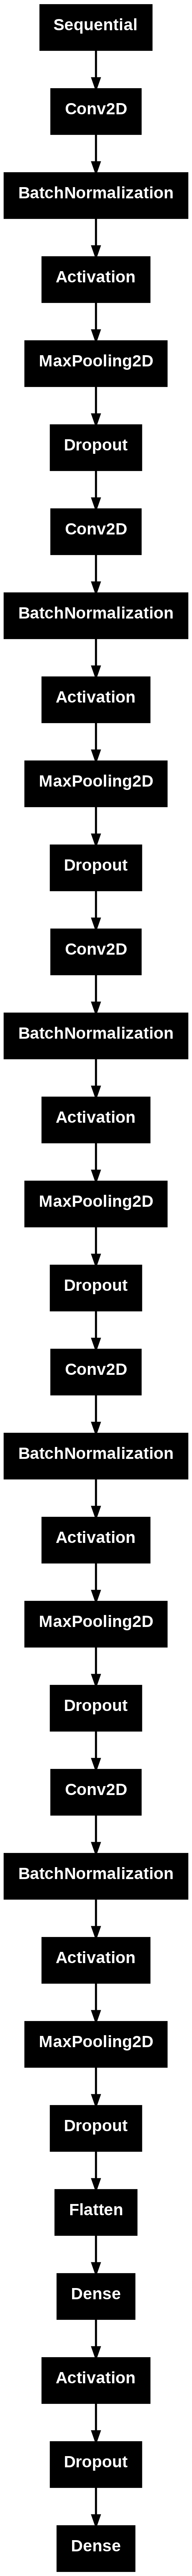

In [ ]:
tf.keras.utils.plot_model(model) # Plotting model

In [ ]:
model.summary() # Printing model summary

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 207,736,011 (792.45 MB)

 Trainable params: 69,244,675 (264.15 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 138,489,352 (528.29 MB)

In [ ]:
# Loading best weights
model.load_weights('best_model.keras')

In [ ]:
preds = model.predict(validation)  # Running model on the validation dataset
val_loss, val_acc = model.evaluate(validation) # Obtaining Loss and Accuracy on the val dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9125 - loss: 0.1949

Validation Loss:  0.19684432446956635

Validation Accuracy:  92.0 %


Picture of a Powdery Plant: 



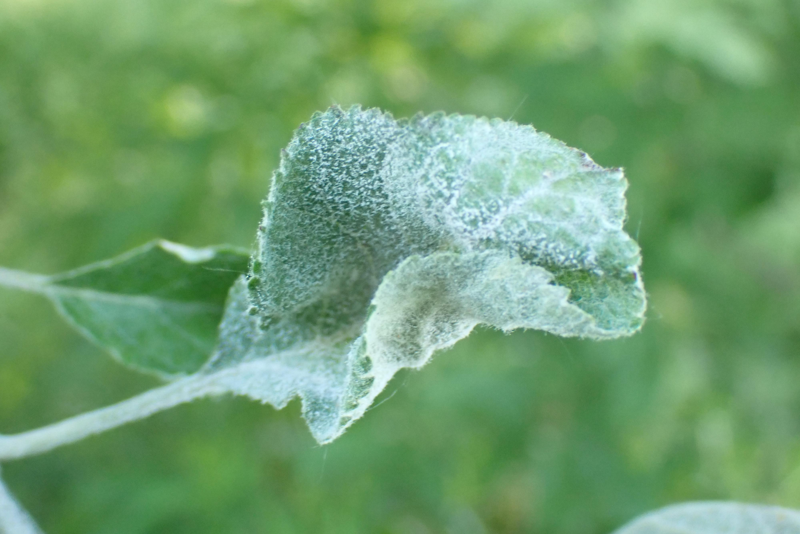

In [ ]:
# Loading an image from the Validation/ Powdery directory

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Loading an image from the Validation/ Powdery directory
image_path = os.path.join(val_dir, 'Powdery', '9bd06de433b285d8.jpg') # Replace 'image_name.jpg' with the actual image file name

original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Powdery Plant: \n')
resized_img

In [ ]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step

Predicted Class: Powdery

Confidence Score: 0.998286783695221


Picture of a Rust Plant: 



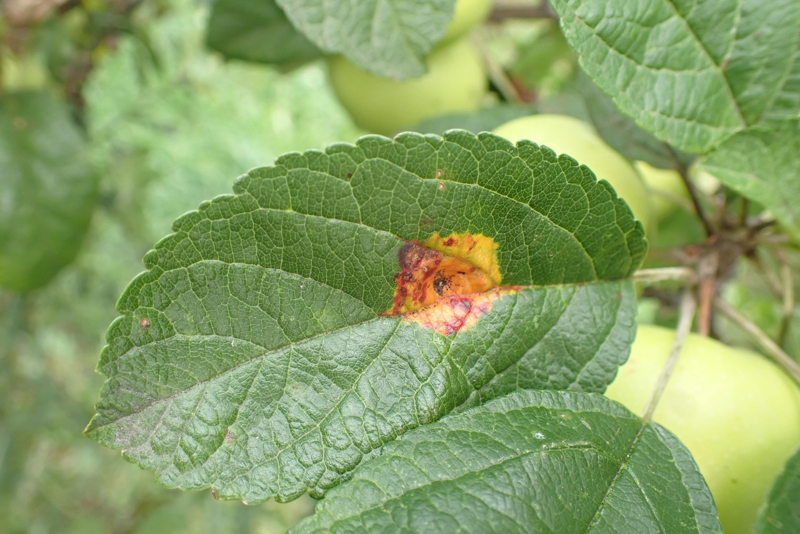

In [ ]:
# Loading an image from the Validation/ Rust directory

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Loading an image from the Validation/ Rust directory
image_path = os.path.join(val_dir, 'Rust', '8152cfbd5a28b5d2.jpg')

original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Rust Plant: \n')
resized_img

In [ ]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step

Predicted Class: Rust

Confidence Score: 1.0


Picture of a Healthy Plant: 



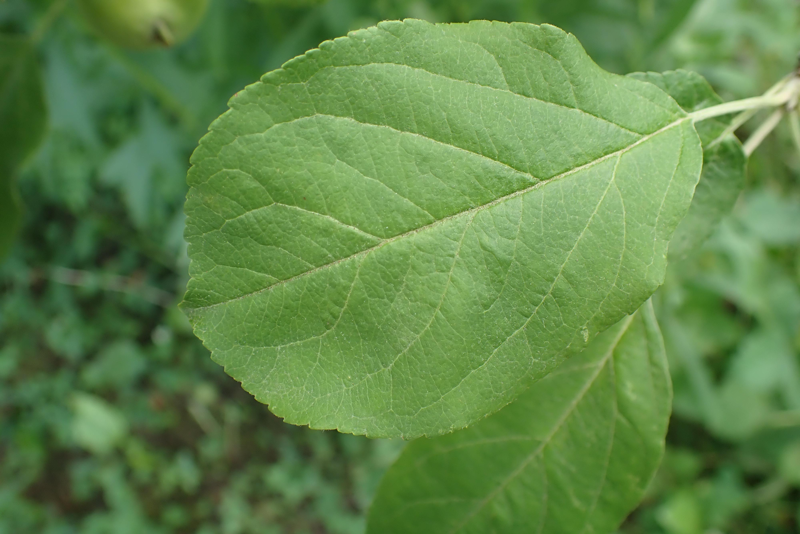

In [ ]:
# Loading an image from the Validation/ Healthy directory

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Loading an image from the Validation/ Healthy directory
image_path = os.path.join(val_dir, 'Healthy', '9c99786a63786571.jpg')

original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Healthy Plant: \n')
resized_img

In [ ]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step

Predicted Class: Healthy

Confidence Score: 0.9969839453697205


Found 150 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.93      0.86      0.90        50
     Powdery       0.92      0.92      0.92        50
        Rust       0.91      0.98      0.94        50

    accuracy                           0.92       150
   macro avg       0.92      0.92      0.92       150
weighted avg       0.92      0.92      0.92       150


Weighted F1-Score: 0.9194



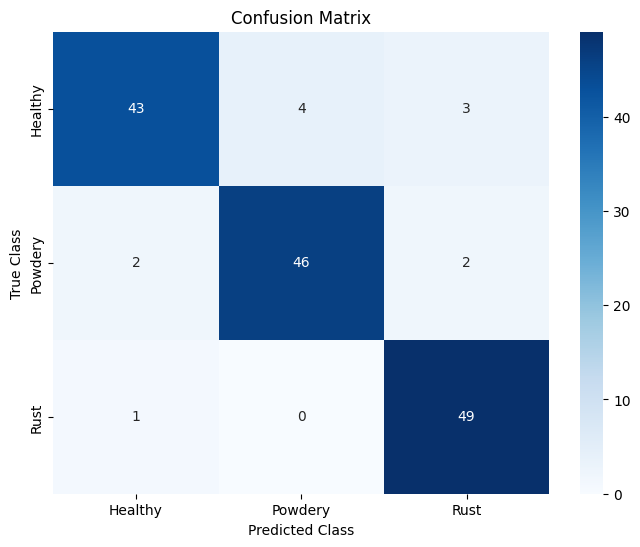

In [ ]:
#Compute Confusion Matrix and Classification Report

import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Preprocessing and Loading Test Data ---
# Set up ImageDataGenerator for preprocessing
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Normalize pixel values to [0, 1]

# Load the test data from directories
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(256, 256),  # Resize images to (256, 256)
    batch_size=32,
    class_mode='categorical',  # For multi-class classification
    shuffle=False  # Disable shuffle to ensure correct labels
)

# --- Getting Predictions ---
# Predict probabilities for test images
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels from test_generator
true_classes = test_generator.classes

# Class indices mapping
class_labels = list(test_generator.class_indices.keys())

# --- Evaluate Metrics ---
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# F1 Score (weighted)
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# --- Print and Visualize Results ---
print("\nClassification Report:\n")
print(report)

print(f"\nWeighted F1-Score: {f1:.4f}\n")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


In [ ]:
model.save('DSGP_my_model.keras')


from google.colab import files
files.download('DSGP_my_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>